# Neural Networks (part 2)

## 1. Introduction 
In this notebook you create a NN for recognizing handwritten digits or fashion items.

#### Refrences:

***MNIST dataset***: Deng, L. (2012). The mnist database of handwritten digit images for machine learning research. IEEE Signal Processing Magazine, 29(6), 141–142.

***Fashion dataset***: Han Xiao and Kashif Rasul and Roland Vollgraf, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms, arXiv, cs.LG/1708.07747


## 2. Loading the data

You make use of the MNIST or the Fashion-MINST dataset. **You get to choose one of them!** Both datasets consist of 70000 images of 28$\times$28 pixels (each pixel has a gray value 0 - 255). The dataset can be downloaded from the internet (see code below). In the text I reference to the images as numbers, if you do the fashion dataset, you can read here fashion items instead.

In [1]:
# importing the required modules
import numpy as np
import matplotlib.pyplot as plt

# to get matplot figures render correctly in the notebook use:
%matplotlib inline 

In [2]:
# Load data from https://www.openml.org/

from sklearn.datasets import fetch_openml

# Pick either the numbers or the fashion database here:
#X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)


X = X.T  # required as the rows should be the features and the columns the samples; shape (784, 70000).
y = y.astype('int')  # y has values as strings ('0', '1', ...'9') and we want integers (0, 1, ..., 9)

# inspect shape.
print(X.shape)
print(y.shape)


### ziopera

(784, 70000)
(70000,)


To have an idea of the data let's print a single sample

label = 0


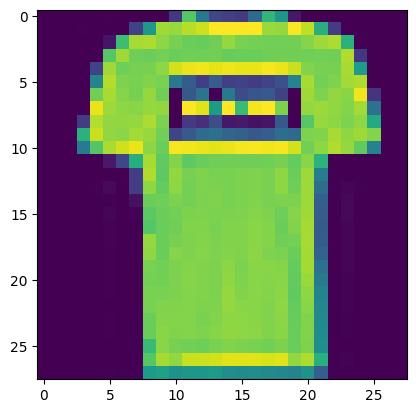

In [3]:
sample = X[:, 1]  # sample number 1
label = y[1]  # label of sample 1
plt.imshow(sample.reshape(28,28))  # need to reshape to a square image of 28 by 28
print(f'label = {label}')

## 3. Create the feature matrix X and labels matrix Y


In [4]:
# rescale feature matrix to values between 0 and 1
X = X / 255.0

print("X shape:", X.shape)
print("Min value:", X.min())
print("Max value:", X.max())


# create one-hot encoded Y matrix
num_classes= 10
Y = np.eye(num_classes)[y]
Y= Y.T
print(Y)

X shape: (784, 70000)
Min value: 0.0
Max value: 1.0
[[0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [5]:
# create a train, validation and test dataset
# for the test data set take the first 5000 samples
# for the train data set take sample 5001 to 60000
# for the validation set take sample 60001 to 70000

#todo
X_test = X[:, :5000]
Y_test = Y[:, :5000]

X_train = X[:, 5000:60000]
Y_train = Y[:, 5000:60000]

X_val = X[:, 60000:]
Y_val = Y[:, 60000:]

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (784, 55000)
Y_train shape: (10, 55000)
X_val shape: (784, 10000)
Y_val shape: (10, 10000)
X_test shape: (784, 5000)
Y_test shape: (10, 5000)


## 4. The Neural Network

The NN that you will make has the following layout (this is something that will work, but feel free to make changes if you like):

- input layer ($l=0$): 784 nodes
- hidden layer ($l=1$): 300 nodes; ReLu activation function
- hidden layer ($l=2$): 100 nodes; ReLu activation function
- output layer ($l=3$): 10 nodes; Softmax activation function


### Define the activation functions

Below you define the required activation functions and their derivatives.

In [11]:
# define some activation functions

def relu(z):
    
    return np.maximum(0,z) 

def relu_diff(z):
    return (z > 0).astype(z.dtype)  # derivative is 1 where z>0, else 0

def softmax(z):
    """
    returns the softmax function of z

    Parameters
    ----------
    z : 2D ndarray

    Returns
    -------
    out : same type and shape as z

    """
    
    '''YOUR CODE GOES HERE '''
    
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def multi_class_crossentropy(Y, A):
    """
    Y, A both shape: (num_classes, batch_size)
    Y is one-hot, A is softmax output
    """
    eps = 1e-15
    return -np.mean(np.sum(Y * np.log(A + eps), axis=0))


### Initalize the weights and biases


In [8]:
# intialize the neural network
rng = np.random.default_rng()

# number of nodes in each layer
n0 = 784
n1 = 300
n2 = 100
n3 = 10

# input layer
# no weights and biases

# hidden layer 1 
W1 = rng.normal(scale=np.sqrt(1/n0), size=(n1,n0))
b1 = np.zeros((n1,1))

# hidden layer 2 
W2 = rng.normal(scale=np.sqrt(1/n1), size=(n2,n1))
b2 = np.zeros((n2,1))

# output layer 
W3 = rng.normal(scale=np.sqrt(1/n1), size=(n3,n2))
b3 = np.zeros((n3,1))


## 5. Train the NN

Firt you define three parameters that can be adjusted for optimal training.
- **learning_rate**: determines to what extend we update the weights and biases in the gradient descent step
- **no_epochs**: the number of times we pass the training data set through the network for training
- **batch_size**: how many samples we pass through the network before doing a gradient descent update

In [9]:
# train settings
learning_rate = 0.1
no_epochs = 1000
batch_size = 10

Below you implement the training of the network. As a start copy and paste your code from part 1. Note that we use the **Cross Entropy** (CE) loss function.

In [12]:
# perform the training
batch_size=16
train_losses = []
train_accuracies = []
m = X_train.shape[1]  
indices = np.arange(m)

def accuracy_score(Y, A):
    # For 10 classes, pick the argmax across rows
    pred_labels = np.argmax(A, axis=0)     
    true_labels = np.argmax(Y, axis=0)     
    return np.mean(pred_labels == true_labels)
    
    
for epoch in range(1, no_epochs + 1):
    np.random.shuffle(indices)
    epoch_loss = 0.0
    epoch_correct = 0.0
    for start_col in range(0,m,batch_size):
        end_col = start_col + batch_size
        
        batch_idx = indices[start_col:end_col]
        
        X_batch = X_train[:, batch_idx] 
        Y_batch = Y_train[:, batch_idx]
        
        # forward pass
        # compute the output of the network for the batch
        z1 = W1 @ X_batch + b1         
        a1 = relu(z1)
        # layer 2 
        z2 = W2 @ a1 + b2              
        a2 = relu(z2)
        # layer 3 with softmax
        z3 = W3 @ a2 + b3               
        a3 = softmax(z3)              
        
        # loss and accuracy
        batch_loss = multi_class_crossentropy(Y_batch, a3)
        batch_acc = accuracy_score(Y_batch, a3) 
        
        # accumulate the loss for average of entire epoch
        epoch_correct += batch_acc * X_batch.shape[1]
        epoch_loss += batch_loss * X_batch.shape[1]
        
        # backward pass
        dz3 = a3 - Y_batch             
        dW3 = (dz3 @ a2.T) / batch_size
        db3 = np.sum(dz3, axis=1, keepdims=True) / batch_size
        # layer2
        dz2 = (W3.T @ dz3) * relu_diff(z2)  
        dW2 = (dz2 @ a1.T) / batch_size
        db2 = np.sum(dz2, axis=1, keepdims=True) / batch_size
        # layer1
        dz1 = (W2.T @ dz2) * relu_diff(z1)   
        dW1 = (dz1 @ X_batch.T) / batch_size
        db1 = np.sum(dz1, axis=1, keepdims=True) / batch_size
        
        # gradient descent step / update weights and biases
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1

    
    # for each epoch evaluate the network performance
    # compute accuracy of train set and store for later analysis
    epoch_loss /= m
    epoch_acc  = epoch_correct / m

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # for each epoch print info on learning progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{no_epochs} "
              f"Loss={epoch_loss:.4f}  Acc={epoch_acc:.4f}")

C:\Users\Mardeen\AppData\Local\Temp\ipykernel_9488\3688740595.py:35: RuntimeWarning: overflow encountered in matmul
  z3 = W3 @ a2 + b3
C:\Users\Mardeen\AppData\Local\Temp\ipykernel_9488\3369957844.py:26: RuntimeWarning: invalid value encountered in subtract
  exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))


KeyboardInterrupt: 

## 6. Analyze the result
Make a plot of the training and validation loss and training and validation accuracy as function of the epoch.

In [ ]:
# plot the loss and accuracy as function of the epoch number
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(train_accuracies)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')

ax2.plot(train_losses)
ax1.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

plt.tight_layout()
plt.show()

'YOUR CODE GOES HERE '

Adapt the hyperparameters and/or NN layout to try to improve the result.

Finally use the test set to check the performance of the model

In [ ]:
# compute the accuracy and losses of the test set
'''TO DO '''
z1_test = W1 @ X_test + b1         
a1_test = relu(z1_test)
# layer 2 
z2_test = W2 @ a1_test + b2              
a2_test = relu(z2_test)
# layer 3 with softmax
z3_test = W3 @ a2_test + b3               
a3_test = softmax(z3_test)              

# loss and accuracy
test_loss = multi_class_crossentropy(Y_test, a3_test)
test_acc = accuracy_score(Y_test, a3_test) 

print(f"Test Loss: {test_loss:.6f}")
print(f"Test Accuracy: {test_acc:.4f}")

'YOUR CODE GOES HERE '

Finally it is interesting to check a few samples and their predicted label

In [ ]:
# check the prediction of 10 random images
'''TO DO '''

random_indices = rng.choice(X_test.shape[1], 10, replace=False)

fig, axes = plt.subplots(2,5, figsize=(12,6))

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    sample = X_test[:, idx]  
    label = np.argmax(a3_test[:, idx]) 
    ax.imshow(sample.reshape(28, 28), cmap="gray") 
    ax.set_title(f"label")  
    ax.axis("off")

plt.show()


'YOUR CODE GOES HERE '

# Neural Networks - The autoencoder **(5EC mandatory)**

You are going to train a neural network that is able to generate a new picture of a any on the 0..9 numbers. The shape of the NN resembles that of a bow tie:

- input layer ($l=0$): 784 nodes
- hidden layer ($l=1$): 300 nodes; ReLu activation function   (FIXED)
- hidden layer ($l=2$): 100 nodes; ReLu activation function   (FIXED)    
- hidden layer ($l=3$): 10 nodes; Softmax activation function  (FIXED)
- hidden layer ($l=4$): ? nodes; ? activation function
- hidden layer ($l=5$): ? nodes; ? activation function
- output layer ($l=6$): 784 nodes; ? activation function

You can train it by passing pictures trough it, the outgoing picture should be almost identical. Think about what loss function would be most appropriate here. Use the weights of the previously trained NN for the left side of the 'bow tie'. This setup is also known as an **autoencoder**. Layers 1-3 function as the _encoder_, wheras the layers 4-6 are the _decoder_. It can be used to find a compressed version of your input data. In case the loss is zero, you have obtained a perfect compression.

Once training is complete you can use the right hand side of the bow tie to generate a new image starting from the input vector, for example, a3 = np.zeros((10)),  a3[3]=1 and see if you get a figure back that resembles a 2.

**Deliverables:** 
1. A plot of 10 newly generated numbers with your network.
2. An outputweights.npz file with all weights and biases of your filal Neural Network (encoder and decoder)
3. A code to read in the outputweights.npz file and use the image generator

_Deliverable 1 could look like:_

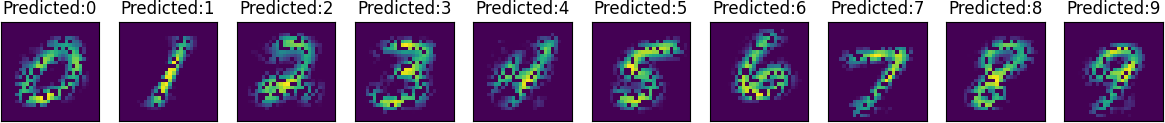
_It would be great if some of you manage to find a solution for the dark (missing) pixels!_     

_Or in case of the fashion set:_

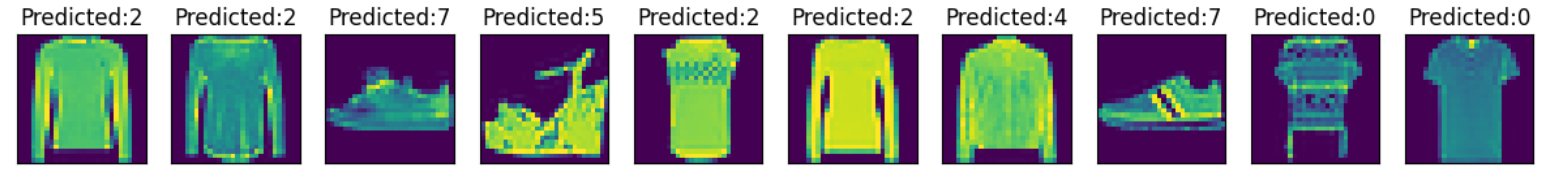

In [13]:
# Setup the Network



In [14]:
# Train the decoder



In [15]:
# Test your image generation and improve your training procedure (hyperparameter tuning)



### Deliverable 1 

In [16]:
# Prove that your network does what it should do and present your deliverable convincingly!



### Deliverable 2                

In [17]:
## saves the obtained weights
#outfile='totalweightsNN.npz'
#np.savez(outfile, W1,...,b1,...)
#npzfile = np.load(outfile)
#npzfile.files
#W1=npzfile['arr_0']
#W1.shape


### Deliverable 3               